# Imports and Setup

In [130]:
#loading in the necessary libraries
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import datetime as dt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from catboost import CatBoostClassifier
from catboost import CatBoostClassifier, Pool, cv
# need to run "pip install wheel" to run shap
import shap
from sklearn.metrics import accuracy_score
from dython.nominal import associations
'''
Stratified K-Fold comes into play for those data sets which are imbalance data sets. This cross validation method 
is a slight variation in the K-Fold cross validation, such that each fold contains approximately same percentage of 
samples of each target class, or in case of prediction problems, the mean response value is approximately equal in 
all the folds.

Repeated means that K-fold is completed many different times possibly
''' 
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib.patches import Circle, Rectangle, Arc

In [45]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
'''
potentially hiding the warnings for presentation purposes
'''
#import warnings
#warnings.filterwarnings('ignore')
#warnings.resetwarnings()

'\npotentially hiding the warnings for presentation purposes\n'

# Guiding Question: 

## How well can I predict if Curry makes a shot based on publicly available information from NBA.com's Advanced Stats page?

In [4]:
'''
importing the data from all of Steph Curry's field goal attempts from NBA.com's Advanced Stats

Used the nba_api library to access the data: https://github.com/swar/nba_api
Specifically using NBA.com's shot chart detail: 
    https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md
'''

# only need to run this once


#from nba_api.stats.endpoints import shotchartdetail
#shotchart = shotchartdetail.ShotChartDetail(player_id = '201939',team_id = '1610612744', context_measure_simple = 'FGA')
#Curry = shotchart.get_data_frames()[0]

'''
download the Curry dataframe as a csv file
'''
#Curry.to_csv(r'/Users/connorcapitolo/Desktop/NBA/Curry shots.csv')

'\ndownload the Curry dataframe as a csv file\n'

In [5]:
'''
viewing the first five rows of the dataframe
'''
Curry = pd.read_csv('/Users/connorcapitolo/Desktop/NBA/Curry-Shot-Prediction/Curry shots.csv', index_col = 0)
Curry.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,20900015,4,201939,Stephen Curry,1610612744,Golden State Warriors,1,11,25,...,Right Side Center(RC),24+ ft.,26,99,249,1,0,20091028,GSW,HOU
1,Shot Chart Detail,20900015,17,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,31,...,Left Side Center(LC),16-24 ft.,18,-122,145,1,1,20091028,GSW,HOU
2,Shot Chart Detail,20900015,53,201939,Stephen Curry,1610612744,Golden State Warriors,1,6,2,...,Center(C),8-16 ft.,14,-60,129,1,0,20091028,GSW,HOU
3,Shot Chart Detail,20900015,141,201939,Stephen Curry,1610612744,Golden State Warriors,2,9,49,...,Left Side(L),16-24 ft.,19,-172,82,1,0,20091028,GSW,HOU
4,Shot Chart Detail,20900015,249,201939,Stephen Curry,1610612744,Golden State Warriors,2,2,19,...,Left Side Center(LC),16-24 ft.,16,-68,148,1,0,20091028,GSW,HOU


In [6]:
'''
this lets me know that there isn't any missing data in the dataset
also, the two data types are integers and strings
'''
Curry.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11928 entries, 0 to 11927
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   GRID_TYPE            11928 non-null  object
 1   GAME_ID              11928 non-null  int64 
 2   GAME_EVENT_ID        11928 non-null  int64 
 3   PLAYER_ID            11928 non-null  int64 
 4   PLAYER_NAME          11928 non-null  object
 5   TEAM_ID              11928 non-null  int64 
 6   TEAM_NAME            11928 non-null  object
 7   PERIOD               11928 non-null  int64 
 8   MINUTES_REMAINING    11928 non-null  int64 
 9   SECONDS_REMAINING    11928 non-null  int64 
 10  EVENT_TYPE           11928 non-null  object
 11  ACTION_TYPE          11928 non-null  object
 12  SHOT_TYPE            11928 non-null  object
 13  SHOT_ZONE_BASIC      11928 non-null  object
 14  SHOT_ZONE_AREA       11928 non-null  object
 15  SHOT_ZONE_RANGE      11928 non-null  object
 16  SHOT

In [7]:
'''
looking specifically at shot distance and shot location, it does appears that there are some outliers 
(a shot 78 feet is almost the length of a basketball court!)
'''
Curry.describe()

,GAME_ID,GAME_EVENT_ID,PLAYER_ID,TEAM_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE
count,1.192800e+04,11928.000000,11928.0,1.192800e+04,11928.000000,11928.000000,11928.000000,11928.000000,11928.000000,11928.000000,11928.0,11928.000000,1.192800e+04
mean,2.138274e+07,266.775319,201939.0,1.610613e+09,2.399061,4.754779,28.580818,17.538565,-0.111502,130.789487,1.0,0.476190,2.014508e+07
std,2.796229e+05,168.137684,0.0,0.000000e+00,1.118473,3.337098,17.574401,10.192440,124.382070,101.555442,0.0,0.499454,2.788051e+04
min,2.090002e+07,2.000000,201939.0,1.610613e+09,1.000000,0.000000,0.000000,0.000000,-250.000000,-41.000000,1.0,0.000000,2.009103e+07
25%,2.120045e+07,106.000000,201939.0,1.610613e+09,1.000000,2.000000,13.000000,9.000000,-95.000000,23.000000,1.0,0.000000,2.012123e+07
50%,2.140068e+07,272.000000,201939.0,1.610613e+09,2.000000,4.000000,29.000000,21.000000,1.000000,141.000000,1.0,0.000000,2.015013e+07
75%,2.160065e+07,392.000000,201939.0,1.610613e+09,3.000000,7.000000,44.000000,25.000000,96.000000,217.000000,1.0,1.000000,2.017012e+07
max,2.190093e+07,752.000000,201939.0,1.610613e+09,6.000000,11.000000,59.000000,78.000000,247.000000,758.000000,1.0,1.000000,2.020030e+07


## Visualizations of Steph Curry Shots

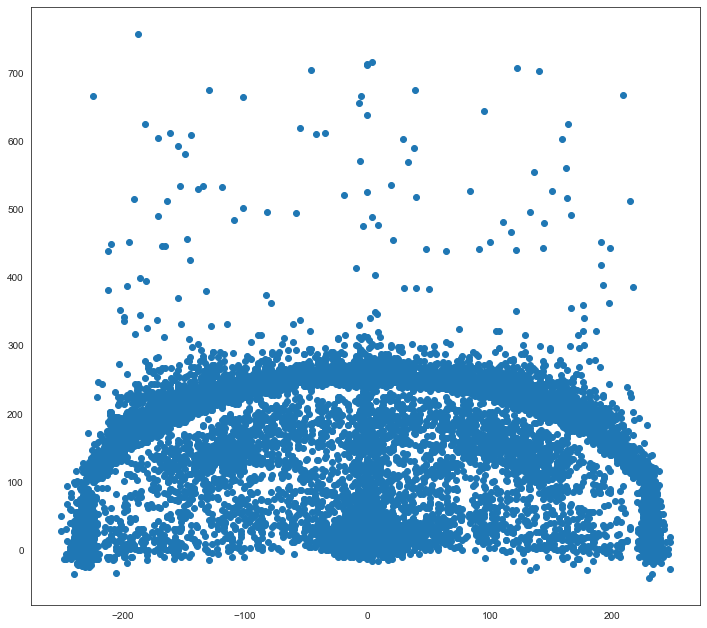

In [8]:
'''
creating a general scatter plot of all Curry's shots
'''
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
plt.scatter(Curry.LOC_X, Curry.LOC_Y)
plt.show()

These shot charts below were created courtesy of Savvas's visualizations http://savvastjortjoglou.com/nba-shot-sharts.html

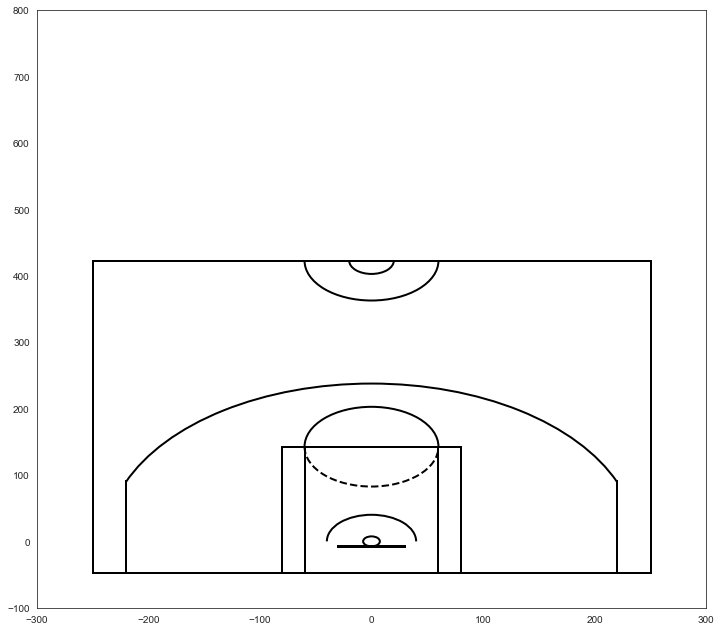

In [9]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    '''Creates a basketball court through matplotlib
    
    Args:
        ax (axis object, optional): If an axes object isn't provided to plot onto, just get current one
        color (string, optional): color of the basketball court
        lw (int, optional): width of each line for the basketball court
        outer_lines (bool, optional): whether the perimeter of the court should be drawn
    '''
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,800)
plt.show()

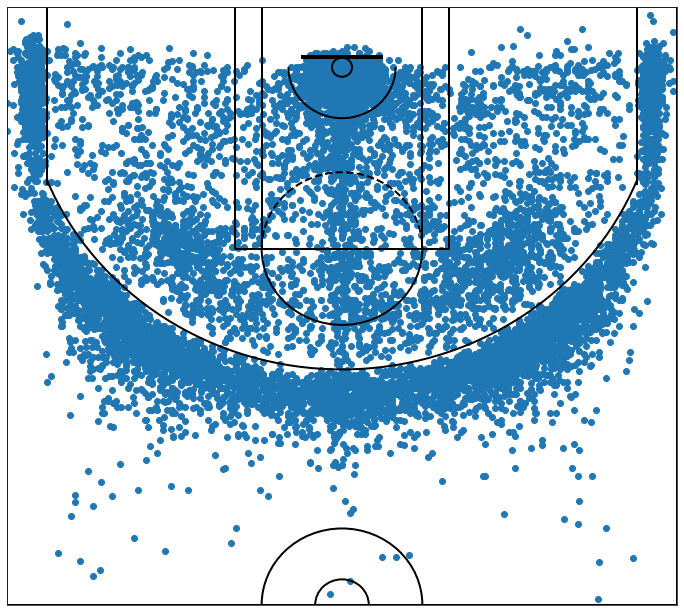

In [10]:
'''
plotting Curry's shots from inside half court
'''
plt.figure(figsize=(12,11))
plt.scatter(Curry.LOC_X, Curry.LOC_Y)
draw_court(outer_lines = True)
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
plt.tick_params(labelbottom=False, labelleft=False)
plt.show()

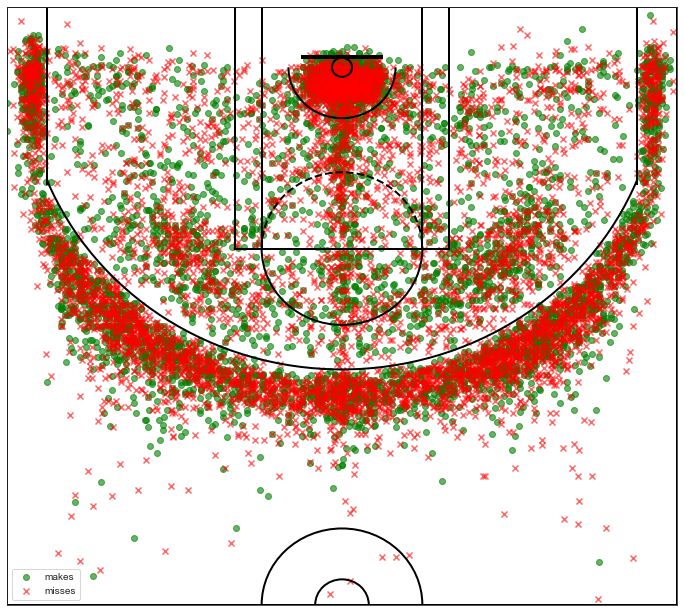

In [11]:
'''
viewing Curry's made and missed shots over the course of his career
'''
plt.figure(figsize=(12,11))
#providing 
plt.scatter(Curry.loc[Curry["SHOT_MADE_FLAG"] == 1,"LOC_X"], 
            Curry.loc[Curry["SHOT_MADE_FLAG"] == 1,"LOC_Y"], c = 'green', label = 'makes', alpha = 0.6)
plt.scatter(Curry.loc[Curry["SHOT_MADE_FLAG"] == 0,"LOC_X"], 
            Curry.loc[Curry["SHOT_MADE_FLAG"] == 0,"LOC_Y"], c = 'red', marker = 'x', label = 'misses', alpha = 0.6)
draw_court(outer_lines = True)
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
plt.tick_params(labelbottom=False, labelleft=False)
#placing the legend in the lower left corner
plt.legend(loc='lower left')
plt.show()

In [12]:
def heatmap_Curry_shots(shot_indicator):
    '''Viewing where most of Curry's shots are made or missed
    
    Args:
        shot_indicator (int): a 1 if wanting to see Curry's makes, 0 if wanting to see Curry's misses
        
    Returns:
        heatmap with Curry's made or missed shots
    '''
    
    # n_levels sets the number of contour lines for the main kde plot
    joint_shot_chart = sns.jointplot(Curry.loc[Curry["SHOT_MADE_FLAG"] == shot_indicator,"LOC_X"], 
                                     Curry.loc[Curry["SHOT_MADE_FLAG"] == shot_indicator,"LOC_Y"], stat_func=None,
                                     kind='kde', cmap = 'hsv',space=0, n_levels=50)

    joint_shot_chart.fig.set_size_inches(12,11)

    # A joint plot has 3 Axes, the first one called ax_joint 
    # is the one we want to draw our court onto and adjust some other settings
    ax = joint_shot_chart.ax_joint
    draw_court(ax)

    # Adjust the axis limits and orientation of the plot in order
    # to plot half court, with the hoop by the top of the plot
    ax.set_xlim(-250,250)
    ax.set_ylim(422.5, -47.5)

    # Get rid of axis labels and tick marks
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.tick_params(labelbottom='off', labelleft='off')

    # Add a title
    if shot_indicator == 1:
        plt.title('Steph Curry Made Shots (Career)')
    else:
        plt.title('Steph Curry Missed Shots (Career)')

    plt.show()

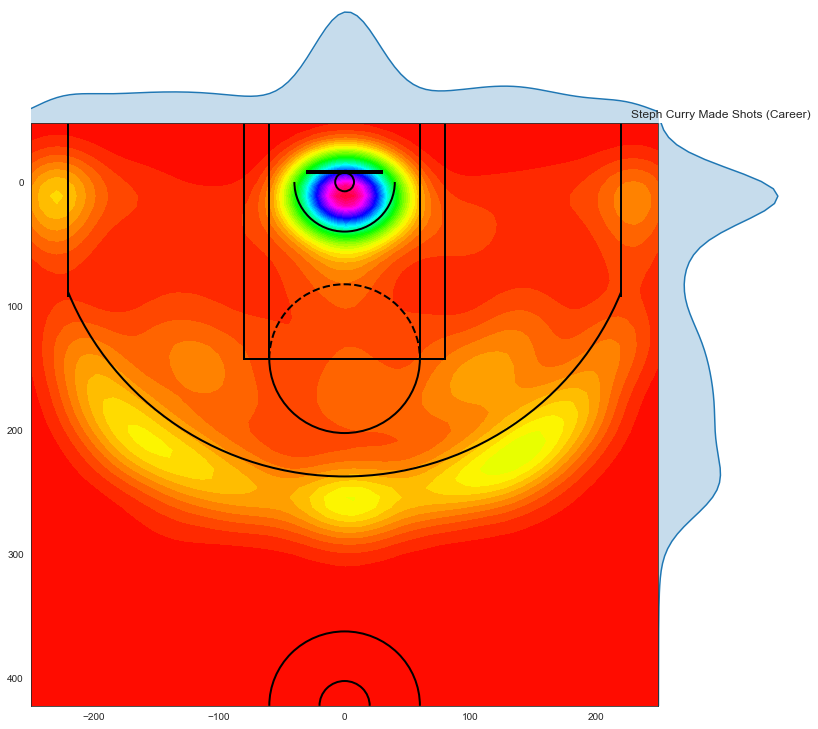

In [13]:
heatmap_Curry_shots(1)

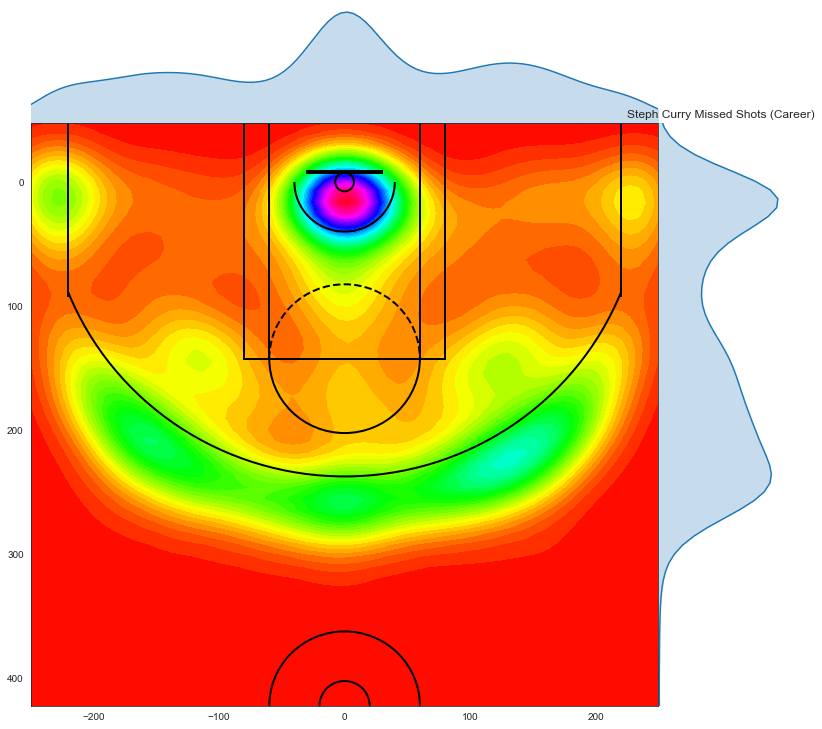

In [14]:
heatmap_Curry_shots(0)

## Dropping Unneccessary Columns (only one unique value)

In [8]:
def only_one_unique(column_list):
    '''print out the unique values in list of columns that should only have one value for Steph Curry
    
    Args:
        column_list(list): a list of columns to examine
    '''
    for column in column_list:
        print(Curry[column].unique())
        
columns = ['GRID_TYPE','TEAM_NAME','TEAM_ID','PLAYER_ID','PLAYER_NAME','EVENT_TYPE','SHOT_ATTEMPTED_FLAG']

only_one_unique(columns)

['Shot Chart Detail']
['Golden State Warriors']
[1610612744]
[201939]
['Stephen Curry']
['Missed Shot' 'Made Shot']
[1]


In [9]:
'''
don't need these columns b/c they are all constants throughout the dataset
'''
drop_columns_Curry = Curry.drop(['GRID_TYPE','TEAM_NAME','TEAM_ID','PLAYER_ID','PLAYER_NAME','SHOT_ATTEMPTED_FLAG'],axis = 1)
print(Curry.shape)
print(drop_columns_Curry.shape)

(11928, 24)
(11928, 18)


In [10]:
with pd.option_context('display.max_columns', None):
    display(drop_columns_Curry.head(7))

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,20900015,4,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,20091028,GSW,HOU
1,20900015,17,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,20091028,GSW,HOU
2,20900015,53,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,20091028,GSW,HOU
3,20900015,141,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,20091028,GSW,HOU
4,20900015,249,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,20091028,GSW,HOU
5,20900015,277,2,0,34,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,20091028,GSW,HOU
6,20900015,413,4,10,26,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,20091028,GSW,HOU


In [11]:
'''
finding how many shots Curry has made and missed in his career
'''
grouped = drop_columns_Curry.groupby('EVENT_TYPE')
print(grouped['SHOT_MADE_FLAG'].size())

EVENT_TYPE
Made Shot      5680
Missed Shot    6248
Name: SHOT_MADE_FLAG, dtype: int64


In [19]:
'''
examining his percentage of makes and misses over the course of his career
'''
makes = sum(drop_columns_Curry['EVENT_TYPE'] == 'Made Shot') / drop_columns_Curry.shape[0]
misses = sum(drop_columns_Curry['EVENT_TYPE'] == 'Missed Shot') / drop_columns_Curry.shape[0]
print("Curry has made {:.3f}% and has missed {:.3f}% of his shots in his career".format(makes, misses))

Curry has made 0.476% and has missed 0.524% of his shots in his career


## Baseline Model must be better than 52.4%, otherwise it's better just to guess he has missed every shot in his career

# Feature Engineering

In [13]:
# checking unique values for each column
drop_columns_Curry.nunique()

GAME_ID              697
GAME_EVENT_ID        704
PERIOD                 6
MINUTES_REMAINING     12
SECONDS_REMAINING     60
EVENT_TYPE             2
ACTION_TYPE           51
SHOT_TYPE              2
SHOT_ZONE_BASIC        7
SHOT_ZONE_AREA         6
SHOT_ZONE_RANGE        5
SHOT_DISTANCE         71
LOC_X                489
LOC_Y                439
SHOT_MADE_FLAG         2
GAME_DATE            697
HTM                   32
VTM                   32
dtype: int64

In [14]:
'''
examining the columns available after dropping the known unneccesary ones
'''
print(drop_columns_Curry.columns.tolist())

['GAME_ID', 'GAME_EVENT_ID', 'PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM']


In [15]:
'''
examining the types of shots that NBA.com categorizes for Curry
'''
print(drop_columns_Curry['ACTION_TYPE'].unique())
print(len(drop_columns_Curry['ACTION_TYPE'].unique()))

['Jump Shot' 'Step Back Jump shot' 'Pullup Jump shot' 'Layup Shot'
 'Jump Bank Shot' 'Driving Layup Shot' 'Reverse Layup Shot'
 'Running Jump Shot' 'Floating Jump shot' 'Driving Finger Roll Layup Shot'
 'Running Hook Shot' 'Driving Reverse Layup Shot' 'Turnaround Jump Shot'
 'Fadeaway Jump Shot' 'Running Layup Shot' 'Running Bank shot'
 'Jump Hook Shot' 'Turnaround Bank shot' 'Driving Bank Hook Shot'
 'Running Reverse Layup Shot' 'Tip Shot' 'Fadeaway Bank shot' 'Hook Shot'
 'Pullup Bank shot' 'Finger Roll Layup Shot' 'Slam Dunk Shot'
 'Turnaround Fadeaway shot' 'Driving Dunk Shot' 'Driving Jump shot'
 'Hook Bank Shot' 'Driving Bank shot' 'Running Bank Hook Shot'
 'Putback Layup Shot' 'Dunk Shot' 'Driving Hook Shot'
 'Running Slam Dunk Shot' 'Running Finger Roll Layup Shot'
 'Driving Slam Dunk Shot' 'Turnaround Hook Shot'
 'Cutting Finger Roll Layup Shot' 'Cutting Layup Shot'
 'Running Pull-Up Jump Shot' 'Driving Floating Jump Shot'
 'Driving Floating Bank Jump Shot' 'Alley Oop Layup sh

In [16]:
def seconds(period, minutes, seconds):
    '''converting the PERIOD, MINUTES_REMAINING, SECONDS_REMAINING columns into a column that provides the number of 
    seconds into the game the shot occurred
    '''
    periods_completed = period - 1
    minutes_into_quarter = 12 - minutes - 1 #subtracting one makes it work with the seconds
    seconds_completed = 60 - seconds
    return (periods_completed * 720) + (minutes_into_quarter*60) + seconds_completed
  
drop_columns_Curry['Seconds Into Game'] = drop_columns_Curry.apply(lambda x: seconds(x['PERIOD'], x['MINUTES_REMAINING'], x['SECONDS_REMAINING']), axis=1)
drop_columns_Curry.head(12)

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,Seconds Into Game
0,20900015,4,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,20091028,GSW,HOU,35
1,20900015,17,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,20091028,GSW,HOU,149
2,20900015,53,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,20091028,GSW,HOU,358
3,20900015,141,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,20091028,GSW,HOU,851
4,20900015,249,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,20091028,GSW,HOU,1301
5,20900015,277,2,0,34,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,20091028,GSW,HOU,1406
6,20900015,413,4,10,26,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,20091028,GSW,HOU,2254
7,20900015,453,4,6,31,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,118,123,1,20091028,GSW,HOU,2489
8,20900015,487,4,2,25,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,20,121,162,1,20091028,GSW,HOU,2735
9,20900015,490,4,1,47,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-125,134,1,20091028,GSW,HOU,2773


In [19]:
'''
examining the 'Season' column

in order to use strptime, need the column to be a string
'''
drop_columns_Curry['Season'] = drop_columns_Curry['GAME_DATE'].astype(str).map(lambda x: dt.datetime.strptime(x,"%Y%m%d").strftime("%Y"))
print(drop_columns_Curry['Season'].describe())
print(drop_columns_Curry['Season'].unique())

count     11928
unique       12
top        2016
freq       1574
Name: Season, dtype: object
['2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018'
 '2019' '2020']


In [20]:
'''
examining how many shots Curry had in each season, starting with the most in 2016

'''
drop_columns_Curry['Season'].value_counts()

2016    1574
2015    1432
2013    1425
2014    1342
2017    1298
2010    1192
2018     967
2019     880
2012     759
2011     729
2009     314
2020      16
Name: Season, dtype: int64

In [21]:
'''
creating a new column that combines data from two separate columns on the location of the shot
'''
drop_columns_Curry['Shot Zone'] = drop_columns_Curry['SHOT_ZONE_BASIC'] + ' on ' + drop_columns_Curry['SHOT_ZONE_AREA']
drop_columns_Curry[['SHOT_ZONE_BASIC','SHOT_ZONE_AREA','Shot Zone']]

,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,Shot Zone
0,Above the Break 3,Right Side Center(RC),Above the Break 3 on Right Side Center(RC)
1,Mid-Range,Left Side Center(LC),Mid-Range on Left Side Center(LC)
2,In The Paint (Non-RA),Center(C),In The Paint (Non-RA) on Center(C)
3,Mid-Range,Left Side(L),Mid-Range on Left Side(L)
4,Mid-Range,Left Side Center(LC),Mid-Range on Left Side Center(LC)
...,...,...,...
11923,Above the Break 3,Right Side Center(RC),Above the Break 3 on Right Side Center(RC)
11924,Above the Break 3,Center(C),Above the Break 3 on Center(C)
11925,Restricted Area,Center(C),Restricted Area on Center(C)
11926,Above the Break 3,Right Side Center(RC),Above the Break 3 on Right Side Center(RC)


In [22]:
'''
creating a new column that says if the shot is from a home game or away game
'''
drop_columns_Curry['Home Game'] = drop_columns_Curry['HTM'].map(lambda x: 1 if x == 'GSW' else 0)
drop_columns_Curry.head(18)

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,...,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,Seconds Into Game,Season,Shot Zone,Home Game
0,20900015,4,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,99,249,0,20091028,GSW,HOU,35,2009,Above the Break 3 on Right Side Center(RC),1
1,20900015,17,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-122,145,1,20091028,GSW,HOU,149,2009,Mid-Range on Left Side Center(LC),1
2,20900015,53,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,-60,129,0,20091028,GSW,HOU,358,2009,In The Paint (Non-RA) on Center(C),1
3,20900015,141,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,-172,82,0,20091028,GSW,HOU,851,2009,Mid-Range on Left Side(L),1
4,20900015,249,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-68,148,0,20091028,GSW,HOU,1301,2009,Mid-Range on Left Side Center(LC),1
5,20900015,277,2,0,34,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,39,15,0,20091028,GSW,HOU,1406,2009,In The Paint (Non-RA) on Center(C),1
6,20900015,413,4,10,26,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-64,149,1,20091028,GSW,HOU,2254,2009,Mid-Range on Left Side Center(LC),1
7,20900015,453,4,6,31,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),...,118,123,1,20091028,GSW,HOU,2489,2009,Mid-Range on Right Side Center(RC),1
8,20900015,487,4,2,25,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),...,121,162,1,20091028,GSW,HOU,2735,2009,Mid-Range on Right Side Center(RC),1
9,20900015,490,4,1,47,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-125,134,1,20091028,GSW,HOU,2773,2009,Mid-Range on Left Side Center(LC),1


In [23]:
'''
creating a new column that provides Curry's opponent
'''
def opponent(home, away):
    if home == 'GSW':
        return away
    return home
  
drop_columns_Curry['Opponent'] = drop_columns_Curry.apply(lambda x: opponent(x['HTM'], x['VTM']), axis=1)
drop_columns_Curry[['HTM','VTM','Opponent']]

,HTM,VTM,Opponent
0,GSW,HOU,HOU
1,GSW,HOU,HOU
2,GSW,HOU,HOU
3,GSW,HOU,HOU
4,GSW,HOU,HOU
...,...,...,...
11923,GSW,TOR,TOR
11924,GSW,TOR,TOR
11925,GSW,TOR,TOR
11926,GSW,TOR,TOR


In [24]:
'''
creating a new column based on whether or not the shot was worth 2 points or 3 points
'''
drop_columns_Curry['2PT FG'] = drop_columns_Curry['SHOT_TYPE'].map(lambda x: 1 if x == '2PT Field Goal' else 0)
drop_columns_Curry[['SHOT_TYPE','2PT FG']].head()

,SHOT_TYPE,2PT FG
0,3PT Field Goal,0
1,2PT Field Goal,1
2,2PT Field Goal,1
3,2PT Field Goal,1
4,2PT Field Goal,1


In [25]:
with pd.option_context('display.max_columns', None):
    display(drop_columns_Curry.head())

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,Seconds Into Game,Season,Shot Zone,Home Game,Opponent,2PT FG
0,20900015,4,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,20091028,GSW,HOU,35,2009,Above the Break 3 on Right Side Center(RC),1,HOU,0
1,20900015,17,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,20091028,GSW,HOU,149,2009,Mid-Range on Left Side Center(LC),1,HOU,1
2,20900015,53,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,20091028,GSW,HOU,358,2009,In The Paint (Non-RA) on Center(C),1,HOU,1
3,20900015,141,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,20091028,GSW,HOU,851,2009,Mid-Range on Left Side(L),1,HOU,1
4,20900015,249,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,20091028,GSW,HOU,1301,2009,Mid-Range on Left Side Center(LC),1,HOU,1


In [26]:
drop_columns_Curry.shape

(11928, 24)

### Deciding on columns that will be used in the data analysis

In [27]:
drop_columns_Curry.columns.tolist()

['GAME_ID',
 'GAME_EVENT_ID',
 'PERIOD',
 'MINUTES_REMAINING',
 'SECONDS_REMAINING',
 'EVENT_TYPE',
 'ACTION_TYPE',
 'SHOT_TYPE',
 'SHOT_ZONE_BASIC',
 'SHOT_ZONE_AREA',
 'SHOT_ZONE_RANGE',
 'SHOT_DISTANCE',
 'LOC_X',
 'LOC_Y',
 'SHOT_MADE_FLAG',
 'GAME_DATE',
 'HTM',
 'VTM',
 'Seconds Into Game',
 'Season',
 'Shot Zone',
 'Home Game',
 'Opponent',
 '2PT FG']

In [30]:
'''
Why I don't need specific columns:
    don't need EVENT_TYPE because SHOT_MADE_FLAG is the binary version
    Seconds Into Game condenses period/minutes/seconds
    SHOT_TYPE is now 2PT FG
    SHOT_ZONE_BASIC and SHOT_ZONE_AREA SHOT_ZONEs are now condensed
    HTM and VTM have been parsed
    GAME_ID provides the same info as GAME_DATE
    GAME_EVENT_ID is only when the event occurred in the game    
'''
x_columns_Curry = drop_columns_Curry.drop(['EVENT_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'HTM', 'VTM', 'GAME_ID', 'GAME_EVENT_ID','SHOT_MADE_FLAG'], axis = 1)
y_column_Curry = drop_columns_Curry['SHOT_MADE_FLAG']
print(x_columns_Curry.shape)
print(y_column_Curry.shape)
print(x_columns_Curry.columns.tolist())

(11928, 15)
(11928,)
['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'GAME_DATE', 'Seconds Into Game', 'Season', 'Shot Zone', 'Home Game', 'Opponent', '2PT FG']


In [31]:
x_columns_Curry.head(5)

,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,ACTION_TYPE,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,GAME_DATE,Seconds Into Game,Season,Shot Zone,Home Game,Opponent,2PT FG
0,1,11,25,Jump Shot,24+ ft.,26,99,249,20091028,35,2009,Above the Break 3 on Right Side Center(RC),1,HOU,0
1,1,9,31,Step Back Jump shot,16-24 ft.,18,-122,145,20091028,149,2009,Mid-Range on Left Side Center(LC),1,HOU,1
2,1,6,2,Jump Shot,8-16 ft.,14,-60,129,20091028,358,2009,In The Paint (Non-RA) on Center(C),1,HOU,1
3,2,9,49,Jump Shot,16-24 ft.,19,-172,82,20091028,851,2009,Mid-Range on Left Side(L),1,HOU,1
4,2,2,19,Jump Shot,16-24 ft.,16,-68,148,20091028,1301,2009,Mid-Range on Left Side Center(LC),1,HOU,1


## Looking at Correlations for Numeric and Categorical Variables

In [110]:
x_columns_Curry.dtypes

PERIOD                int64
MINUTES_REMAINING     int64
SECONDS_REMAINING     int64
ACTION_TYPE          object
SHOT_ZONE_RANGE      object
SHOT_DISTANCE         int64
LOC_X                 int64
LOC_Y                 int64
GAME_DATE             int64
Seconds Into Game     int64
Season               object
Shot Zone            object
Home Game             int64
Opponent             object
2PT FG                int64
dtype: object

##### Examining distributions of numeric variables to see if I should use Pearson (for normally distributed data) or Spearman (rank) correlations

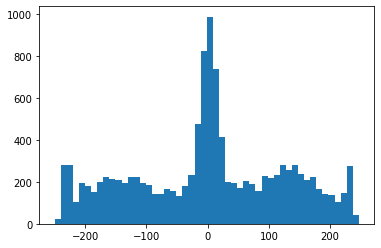

In [113]:
plt.hist(x_columns_Curry['LOC_X'], bins = 50)
plt.show()

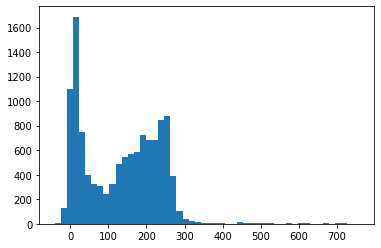

In [114]:
plt.hist(x_columns_Curry['LOC_Y'], bins = 50)
plt.show()

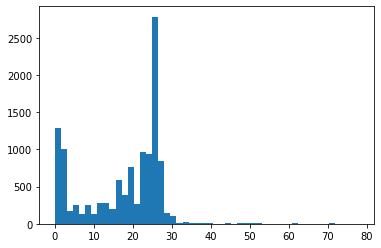

In [115]:
plt.hist(x_columns_Curry['SHOT_DISTANCE'], bins = 50)
plt.show()

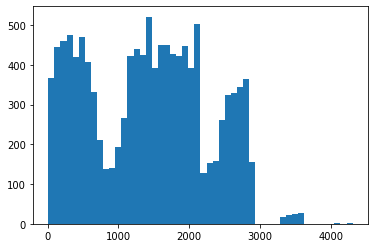

In [116]:
plt.hist(x_columns_Curry['Seconds Into Game'], bins = 50)
plt.show()

#### Using Spearman since three out of the four numeric variables don't appear to be normally distributed

In [118]:
x_columns_Curry[['SHOT_DISTANCE','LOC_X','LOC_Y','Seconds Into Game']].corr(method = 'spearman')

,SHOT_DISTANCE,LOC_X,LOC_Y,Seconds Into Game
SHOT_DISTANCE,1.000000,0.005644,0.831197,0.021821
LOC_X,0.005644,1.000000,0.044326,0.044204
LOC_Y,0.831197,0.044326,1.000000,0.032823
Seconds Into Game,0.021821,0.044204,0.032823,1.000000


In [32]:
skew_of_numerical = x_columns_Curry[['SHOT_DISTANCE','LOC_X','LOC_Y','Seconds Into Game']].skew()
skew_of_numerical

SHOT_DISTANCE       -0.206617
LOC_X               -0.081218
LOC_Y                0.454312
Seconds Into Game    0.083814
dtype: float64

#### Running Thiel's U on categorical variables

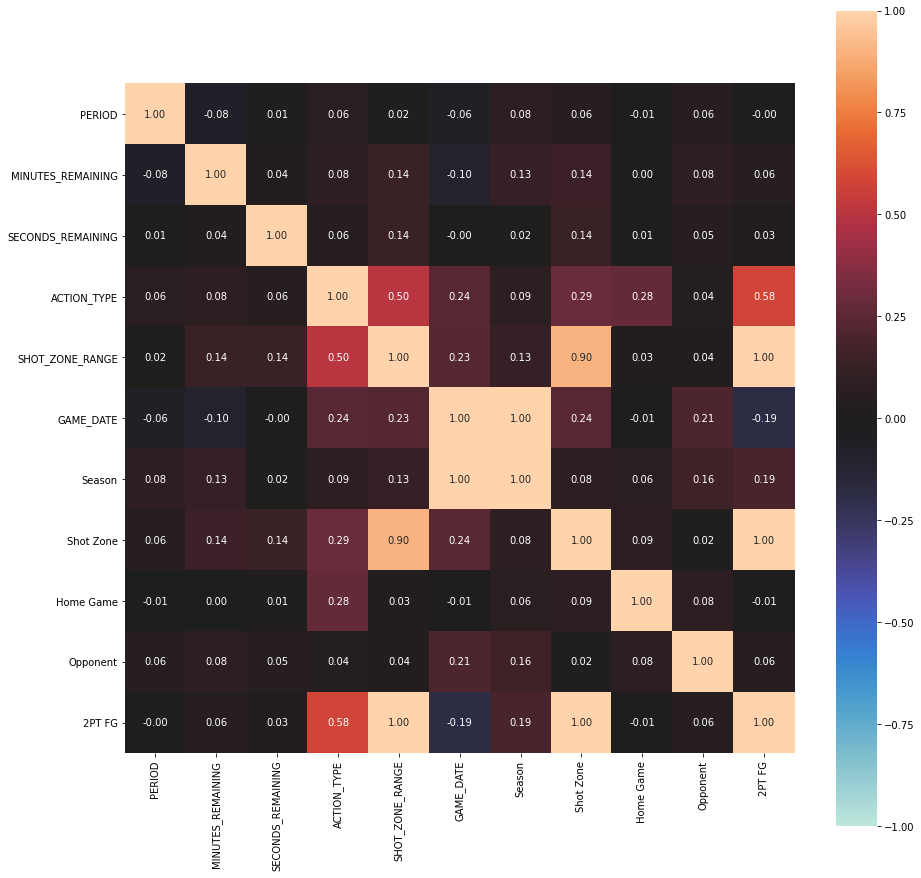

{'corr':                      PERIOD  MINUTES_REMAINING  SECONDS_REMAINING  \
 PERIOD             1.000000          -0.077965           0.008003   
 MINUTES_REMAINING -0.077965           1.000000           0.037451   
 SECONDS_REMAINING  0.008003           0.037451           1.000000   
 ACTION_TYPE        0.064843           0.082395           0.055603   
 SHOT_ZONE_RANGE    0.023311           0.139267           0.135187   
 GAME_DATE         -0.060903          -0.099335          -0.004483   
 Season             0.079853           0.131118           0.023051   
 Shot Zone          0.057167           0.144665           0.136295   
 Home Game         -0.005323           0.000904           0.010148   
 Opponent           0.059876           0.084648           0.049401   
 2PT FG            -0.004349           0.056439           0.026368   
 
                    ACTION_TYPE  SHOT_ZONE_RANGE  GAME_DATE    Season  \
 PERIOD                0.064843         0.023311  -0.060903  0.079853   
 MIN

In [121]:
associations(x_columns_Curry.drop(['SHOT_DISTANCE','LOC_X','LOC_Y','Seconds Into Game'], axis = 1), figsize = (15,15))

In [122]:
pd.crosstab(x_columns_Curry['2PT FG'], x_columns_Curry['SHOT_ZONE_RANGE'])

SHOT_ZONE_RANGE,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
2PT FG,,,,,
0,0,5656,0,80,0
1,2199,0,1133,0,2860


In [124]:
pd.crosstab(x_columns_Curry['2PT FG'], x_columns_Curry['Shot Zone'])

Shot Zone,Above the Break 3 on Back Court(BC),Above the Break 3 on Center(C),Above the Break 3 on Left Side Center(LC),Above the Break 3 on Right Side Center(RC),Backcourt on Back Court(BC),In The Paint (Non-RA) on Center(C),In The Paint (Non-RA) on Left Side(L),In The Paint (Non-RA) on Right Side(R),Left Corner 3 on Left Side(L),Mid-Range on Center(C),Mid-Range on Left Side Center(LC),Mid-Range on Left Side(L),Mid-Range on Right Side Center(RC),Mid-Range on Right Side(R),Restricted Area on Center(C),Right Corner 3 on Right Side(R)
2PT FG,,,,,,,,,,,,,,,,
0,4,1330,1663,1792,76,0,0,0,509,0,0,0,0,0,0,362
1,0,0,0,0,0,940,54,58,0,535,577,514,703,511,2300,0


In [125]:
pd.crosstab(x_columns_Curry['SHOT_ZONE_RANGE'], x_columns_Curry['Shot Zone'])

Shot Zone,Above the Break 3 on Back Court(BC),Above the Break 3 on Center(C),Above the Break 3 on Left Side Center(LC),Above the Break 3 on Right Side Center(RC),Backcourt on Back Court(BC),In The Paint (Non-RA) on Center(C),In The Paint (Non-RA) on Left Side(L),In The Paint (Non-RA) on Right Side(R),Left Corner 3 on Left Side(L),Mid-Range on Center(C),Mid-Range on Left Side Center(LC),Mid-Range on Left Side(L),Mid-Range on Right Side Center(RC),Mid-Range on Right Side(R),Restricted Area on Center(C),Right Corner 3 on Right Side(R)
SHOT_ZONE_RANGE,,,,,,,,,,,,,,,,
16-24 ft.,0,0,0,0,0,0,0,0,0,429,577,256,703,234,0,0
24+ ft.,0,1330,1663,1792,0,0,0,0,509,0,0,0,0,0,0,362
8-16 ft.,0,0,0,0,0,380,54,58,0,106,0,258,0,277,0,0
Back Court Shot,4,0,0,0,76,0,0,0,0,0,0,0,0,0,0,0
Less Than 8 ft.,0,0,0,0,0,560,0,0,0,0,0,0,0,0,2300,0


I should remove one of 2 PT FG, SHOT_ZONE_RANGE, or Shot Zone

# Splitting The Data 

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(x_columns_Curry, y_column_Curry, test_size = 0.25, shuffle = True, random_state = 1)

In [34]:
def confirming_stratified_split(y):
    '''examining the number of makes and misses for the training and test sets to confirm they resemble the accuracy
    of Curry's makes and misses in his career (~52% missed, ~48% made)
    
    Args:
        y (Series): y values for the trianing set or the test set that's composed of 0 (misses) and 1 (makes)
    
    Returns:
        misses (float): about how much of the data set is composed of 0
        makes (float): about how much of the data set is composed of 1
    '''
    value_counts = y.value_counts()
    missed_shots_percent = value_counts[0] / value_counts.sum(axis = 0)
    made_shots_percent = value_counts[1] / value_counts.sum(axis = 0)
    misses = round(missed_shots_percent,3)
    makes = round(made_shots_percent,3)
    return misses, makes

In [35]:
'''
examining training set
'''
train_misses, train_makes = confirming_stratified_split(Y_train)
print("In the training set, Curry missed {} of his shots and made {} of his shots".format(train_misses,train_makes))
test_misses, test_makes = confirming_stratified_split(Y_test)
print("In the test set, Curry missed {} of his shots and made {} of his shots".format(test_misses,test_makes))

In the training set, Curry missed 0.526 of his shots and made 0.474 of his shots
In the test set, Curry missed 0.516 of his shots and made 0.484 of his shots


In [42]:
def unique_features(dataset, df_name):
    '''Checking the number of unique values in the four large category columns for train or test sets
    
    Args:
        column_list (list): the columns to examine
        dataset (DataFrame): either the independent variables for the train or test sets
        df_name (str): identifying whether it's the train or test set
    '''
    for i in dataset.columns.tolist():
        print("The column {} has {} unique features in the {} set".format(i,len(dataset[i].unique()), df_name))
    print('\n')

unique_features(X_train, 'train')
unique_features(X_test, 'test')

The column PERIOD has 6 unique features in the train set
The column MINUTES_REMAINING has 12 unique features in the train set
The column SECONDS_REMAINING has 60 unique features in the train set
The column ACTION_TYPE has 50 unique features in the train set
The column SHOT_ZONE_RANGE has 5 unique features in the train set
The column SHOT_DISTANCE has 66 unique features in the train set
The column LOC_X has 483 unique features in the train set
The column LOC_Y has 416 unique features in the train set
The column GAME_DATE has 697 unique features in the train set
The column Seconds Into Game has 2660 unique features in the train set
The column Season has 12 unique features in the train set
The column Shot Zone has 16 unique features in the train set
The column Home Game has 2 unique features in the train set
The column Opponent has 31 unique features in the train set
The column 2PT FG has 2 unique features in the train set


The column PERIOD has 6 unique features in the test set
The colu

In [43]:
print(X_train.columns.tolist())
print(X_test.columns.tolist())

['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'GAME_DATE', 'Seconds Into Game', 'Season', 'Shot Zone', 'Home Game', 'Opponent', '2PT FG']
['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'GAME_DATE', 'Seconds Into Game', 'Season', 'Shot Zone', 'Home Game', 'Opponent', '2PT FG']


# Machine Learning Analysis

## Catboost

In [51]:
'''
Obtaining the indices for the categorical features
'''

cat_col_names = ['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 'SHOT_ZONE_RANGE', 'GAME_DATE', 'Season', 'Shot Zone', 'Home Game', 'Opponent', '2PT FG']

cat_features = []
for col_name in X_train.columns:
    if col_name in cat_col_names:
        cat_features.append(X_train.columns.get_loc(col_name))
        
print(cat_features)

[0, 1, 2, 3, 4, 8, 10, 11, 12, 13, 14]


In [56]:
'''
performing default CatBoost to see what the potential results are
'''

model = CatBoostClassifier(
    random_seed=63,
    custom_loss=['Accuracy'],
    early_stopping_rounds = 50,
    train_dir = 'accuracy'
)
model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_test, Y_test),
    verbose=True,
    plot = True
)

Learning rate set to 0.054445


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6868650	test: 0.6868709	best: 0.6868709 (0)	total: 33ms	remaining: 33s
1:	learn: 0.6800620	test: 0.6803731	best: 0.6803731 (1)	total: 57.1ms	remaining: 28.5s
2:	learn: 0.6742808	test: 0.6745811	best: 0.6745811 (2)	total: 80.5ms	remaining: 26.8s
3:	learn: 0.6699611	test: 0.6700385	best: 0.6700385 (3)	total: 101ms	remaining: 25.2s
4:	learn: 0.6662544	test: 0.6661402	best: 0.6661402 (4)	total: 112ms	remaining: 22.3s
5:	learn: 0.6614646	test: 0.6612225	best: 0.6612225 (5)	total: 133ms	remaining: 22.1s
6:	learn: 0.6581862	test: 0.6579398	best: 0.6579398 (6)	total: 148ms	remaining: 21s
7:	learn: 0.6550675	test: 0.6547503	best: 0.6547503 (7)	total: 169ms	remaining: 21s
8:	learn: 0.6514153	test: 0.6511628	best: 0.6511628 (8)	total: 197ms	remaining: 21.7s
9:	learn: 0.6486167	test: 0.6482798	best: 0.6482798 (9)	total: 227ms	remaining: 22.5s
10:	learn: 0.6454965	test: 0.6454134	best: 0.6454134 (10)	total: 249ms	remaining: 22.4s
11:	learn: 0.6426705	test: 0.6428142	best: 0.6428142 (11)

In [55]:
model.best_score_

{'learn': {'Accuracy': 0.7186452045606975, 'Logloss': 0.5475016347801197},
 'validation': {'Accuracy': 0.6666666666666666, 'Logloss': 0.6087507796128689}}

### CatBoost Cross Validation (CV)

In [63]:
# setting the cross validation parameters
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_params

{'random_seed': 63,
 'train_dir': 'accuracy',
 'custom_loss': ['Accuracy'],
 'early_stopping_rounds': 50,
 'loss_function': 'Logloss'}

In [64]:
%%time
cv_data = cv(
    Pool(X_train, Y_train, cat_features=cat_features),
    cv_params,
    plot=True,
    verbose = True,
    stratified = True,
    fold_count = 10
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6896305	test: 0.6897178	best: 0.6897178 (0)	total: 355ms	remaining: 5m 54s
1:	learn: 0.6861898	test: 0.6862933	best: 0.6862933 (1)	total: 492ms	remaining: 4m 5s
2:	learn: 0.6827478	test: 0.6829529	best: 0.6829529 (2)	total: 693ms	remaining: 3m 50s
3:	learn: 0.6795355	test: 0.6798219	best: 0.6798219 (3)	total: 868ms	remaining: 3m 36s
4:	learn: 0.6765010	test: 0.6768283	best: 0.6768283 (4)	total: 1.05s	remaining: 3m 29s
5:	learn: 0.6738635	test: 0.6742254	best: 0.6742254 (5)	total: 1.19s	remaining: 3m 17s
6:	learn: 0.6712134	test: 0.6716172	best: 0.6716172 (6)	total: 1.33s	remaining: 3m 8s
7:	learn: 0.6687601	test: 0.6691211	best: 0.6691211 (7)	total: 1.48s	remaining: 3m 3s
8:	learn: 0.6662973	test: 0.6665948	best: 0.6665948 (8)	total: 1.63s	remaining: 2m 59s
9:	learn: 0.6640318	test: 0.6644355	best: 0.6644355 (9)	total: 1.76s	remaining: 2m 54s
10:	learn: 0.6619384	test: 0.6624050	best: 0.6624050 (10)	total: 1.9s	remaining: 2m 50s
11:	learn: 0.6599020	test: 0.6604042	best: 0.

In [65]:
print('Best validation accuracy score: {:.4f}±{:.4f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.6614±0.0130 on step 51


### CatBoost Bayesian Optimization

In [91]:
import hyperopt

def hyperopt_objective(params):
    bayesian_model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        depth = params['depth'],
        early_stopping_rounds = 50,
        eval_metric='Accuracy',
        random_seed=63,
        loss_function='Logloss',
    )
    
    cv_data = cv(
    Pool(X_train, Y_train, cat_features=cat_features), bayesian_model.get_params(),
    stratified = True,
    fold_count = 10
)
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])
    
    return 1 - best_accuracy # as hyperopt minimises

In [92]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
    'depth': hyperopt.hp.choice('depth', [5,  2,  3,  4,  1,  6,  7,  8,  9, 10, 11, 12, 13])
}

trials = hyperopt.Trials()

In [93]:
%%time
# the higher the max_evals, the better the result may be
#  By default, tpe performs the first 20 evaluations randomly as a warm up to get an idea of where to start.
best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=RandomState(123)
)

0:	learn: 0.6590655	test: 0.6583962	best: 0.6583962 (0)	total: 333ms	remaining: 5m 32s

1:	learn: 0.6607795	test: 0.6614136	best: 0.6614136 (1)	total: 506ms	remaining: 4m 12s

2:	learn: 0.6623570	test: 0.6610776	best: 0.6614136 (1)	total: 707ms	remaining: 3m 55s

3:	learn: 0.6641951	test: 0.6617485	best: 0.6617485 (3)	total: 926ms	remaining: 3m 50s

4:	learn: 0.6661451	test: 0.6624184	best: 0.6624184 (4)	total: 1.24s	remaining: 4m 6s

5:	learn: 0.6674864	test: 0.6617483	best: 0.6624184 (4)	total: 1.5s	remaining: 4m 7s

6:	learn: 0.6697593	test: 0.6613010	best: 0.6624184 (4)	total: 1.73s	remaining: 4m 5s

7:	learn: 0.6708771	test: 0.6585053	best: 0.6624184 (4)	total: 2.02s	remaining: 4m 10s

8:	learn: 0.6727277	test: 0.6594005	best: 0.6624184 (4)	total: 2.26s	remaining: 4m 8s

9:	learn: 0.6747149	test: 0.6599594	best: 0.6624184 (4)	total: 2.52s	remaining: 4m 9s

10:	learn: 0.6756340	test: 0.6591766	best: 0.6624184 (4)	total: 2.75s	remaining: 4m 7s

11:	learn: 0.6769754	test: 0.6592888	b

In [94]:
print(best)

{'depth': 9, 'l2_leaf_reg': 4.0, 'learning_rate': 0.2237302623399975}


In [96]:
trials.best_trial

{'state': 2,
 'tid': 24,
 'spec': None,
 'result': {'loss': 0.336125710479102, 'status': 'ok'},
 'misc': {'tid': 24,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'depth': [24], 'l2_leaf_reg': [24], 'learning_rate': [24]},
  'vals': {'depth': [9],
   'l2_leaf_reg': [4.0],
   'learning_rate': [0.2237302623399975]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 8, 3, 3, 44, 15, 122000),
 'refresh_time': datetime.datetime(2020, 8, 3, 3, 44, 37, 222000)}

In [99]:
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    depth = best['depth'],
    early_stopping_rounds = 50,
    eval_metric='Accuracy',
    random_seed=63,
    loss_function='Logloss',
    train_dir = 'accuracy'
)
cv_data = cv(Pool(X_train, Y_train, cat_features=cat_features), model.get_params())

0:	learn: 0.6616920	test: 0.6591767	best: 0.6591767 (0)	total: 118ms	remaining: 1m 57s
1:	learn: 0.6650450	test: 0.6591765	best: 0.6591767 (0)	total: 193ms	remaining: 1m 36s
2:	learn: 0.6647658	test: 0.6595119	best: 0.6595119 (2)	total: 283ms	remaining: 1m 34s
3:	learn: 0.6680634	test: 0.6577232	best: 0.6595119 (2)	total: 495ms	remaining: 2m 3s
4:	learn: 0.6713609	test: 0.6582825	best: 0.6595119 (2)	total: 642ms	remaining: 2m 7s
5:	learn: 0.6736525	test: 0.6586178	best: 0.6595119 (2)	total: 761ms	remaining: 2m 6s
6:	learn: 0.6779561	test: 0.6583942	best: 0.6595119 (2)	total: 864ms	remaining: 2m 2s
7:	learn: 0.6801914	test: 0.6571643	best: 0.6595119 (2)	total: 958ms	remaining: 1m 58s
8:	learn: 0.6839919	test: 0.6574997	best: 0.6595119 (2)	total: 1.19s	remaining: 2m 10s
9:	learn: 0.6864514	test: 0.6585057	best: 0.6595119 (2)	total: 1.33s	remaining: 2m 12s
10:	learn: 0.6893577	test: 0.6591766	best: 0.6595119 (2)	total: 1.47s	remaining: 2m 12s
11:	learn: 0.6932142	test: 0.6579468	best: 0.6

In [100]:
print('Precise validation accuracy score: {}'.format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.6614118469137721


# Final Results

In [108]:
# iterations is another hyperparameter that can be tuned; I just used the cross-validation iteration stopping (16) from above
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    depth = best['depth'],
    iterations = 16,
    eval_metric='Accuracy',
    random_seed=63,
    loss_function='Logloss',
    verbose = True
)
model.fit(X_train, Y_train, cat_features=cat_features)

0:	learn: 0.6570534	total: 24.8ms	remaining: 373ms
1:	learn: 0.6581712	total: 51.8ms	remaining: 362ms
2:	learn: 0.6591773	total: 70.9ms	remaining: 307ms
3:	learn: 0.6609658	total: 83.2ms	remaining: 250ms
4:	learn: 0.6600715	total: 90.2ms	remaining: 198ms
5:	learn: 0.6617483	total: 100ms	remaining: 167ms
6:	learn: 0.6624190	total: 111ms	remaining: 142ms
7:	learn: 0.6625307	total: 121ms	remaining: 121ms
8:	learn: 0.6630896	total: 130ms	remaining: 101ms
9:	learn: 0.6637603	total: 135ms	remaining: 80.9ms
10:	learn: 0.6627543	total: 144ms	remaining: 65.7ms
11:	learn: 0.6629779	total: 158ms	remaining: 52.7ms
12:	learn: 0.6638721	total: 169ms	remaining: 38.9ms
13:	learn: 0.6657724	total: 179ms	remaining: 25.6ms
14:	learn: 0.6666667	total: 190ms	remaining: 12.7ms
15:	learn: 0.6677845	total: 200ms	remaining: 0us


In [109]:
Y_pred = model.predict(X_test)
accuracy_score(Y_test, Y_pred)

0.6659959758551308

## Results: Obtained an accuracy of ~66.6% using CatBoost

# Feature Importance

In [127]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,ACTION_TYPE,38.084557
1,Home Game,14.343035
2,SHOT_DISTANCE,9.077545
3,Shot Zone,6.767329
4,MINUTES_REMAINING,6.171002
5,Season,5.637889
6,SECONDS_REMAINING,5.088421
7,SHOT_ZONE_RANGE,4.201148
8,Opponent,4.088590
9,LOC_Y,1.965827


In [128]:
shap_values = model.get_feature_importance(Pool(data=x_columns_Curry, label=y_column_Curry, cat_features=cat_features), type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(11928, 15)


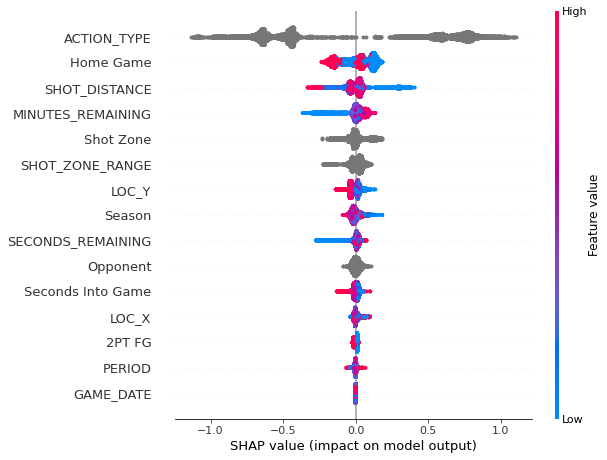

In [129]:
shap.summary_plot(shap_values, x_columns_Curry)